# 导师制名企实训班商业智能方向 004期 Lesson 17

### Thinking 1： 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一

时序数据库是主要存储时序数据的数据库，相较于传统关系数据库有更多针对时序数据的优化。时序数据是一系列按照时间顺序生成或保存的数据，其主要以时间维度为索引。  
时序数据常常是一些实时监控数据，他们随着时间生成，并且通常是同时生成不同维度乃至不同模态的数据。随着移动互联网、万物互联技术的发展，人们主动（撰写微博、发朋友圈等）和被动（步数、地点信息、购买记录等）产生的信息被采集并传输到服务器上保存下来，这些信息随着时间增长并且高并发，往往也会保留历史信息而不是覆盖，所以会成为增长最快的数据类型之一。

### Action 1：PM2.5数据集
https://archive.ics.uci.edu/ml/datasets/Beijing%20PM2.5%20Data  
预测未来北京PM2.5的值  

In [1]:
import pandas as pd

In [2]:
# 数据加载
dataset = pd.read_csv('data/pollution.csv', index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [3]:
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [4]:
# 一共有8个特征
groups = list(range(8))
groups

[0, 1, 2, 3, 4, 5, 6, 7]

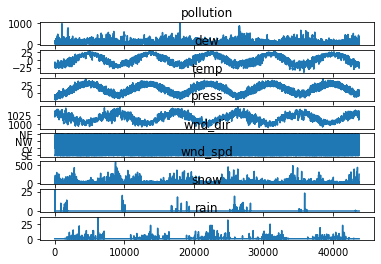

In [5]:
import matplotlib.pyplot as plt
for group in groups:
    # 8行1列， 第group+1
    plt.subplot(8, 1, group+1)
    # 原始特征values中的group列进行可视化
    plt.plot(values[:, group])
    plt.title(dataset.columns[group])
plt.show()

In [6]:
# 将分类特征wnd_dir进行标签编码
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 设置数据类型为float32
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled.shape

(43800, 8)

In [12]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    data: 观察序列
    n_in: 观察数据input(x)的步长，范围[1, len(data)]，默认为1
    n_out： output(y)的步长，默认1
    dropnan： 是否删除NaN行
    return: 适用于监督学习的DataFrame
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [13]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
reframed.to_csv('reframed-1.csv')
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [14]:
# 去掉不需要预测的列，即var2(t) var3(t) var4(t) var5(t) var6(t) var7(t) var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [15]:
# 数据集切分， 80%为训练集， 20%为测试集
values = reframed.values
# LSTM 不能采用train_test_split()，因为时间序列不连续
# XGBoost可以，因为样本是相互独立的

In [16]:
n_train_hours = int(len(values)* 0.8)
# :n_train_hours代表前n_train_hours行，后面：代表所有列
train = values[:n_train_hours, :]
# n_train_hours:代表 从n_train_hours开始到结束的行
test = values[n_train_hours:, :]

In [18]:
# :-1 代表从0到数组最后一位， -1代表数组最后一位
train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:,:-1], test[:, -1]
train_X.shape

(35039, 8)

In [19]:
train_y.shape

(35039,)

In [20]:
# 转换为3D格式 【样本数， 时间步，特征数】
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [28]:
# 设置网络模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# 模型训练
result = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35039 samples, validate on 8760 samples
Epoch 1/10
35039/35039 - 6s - loss: 0.0044 - val_loss: 0.0077
Epoch 2/10
35039/35039 - 5s - loss: 9.8795e-04 - val_loss: 0.0039
Epoch 3/10
35039/35039 - 5s - loss: 8.2890e-04 - val_loss: 0.0022
Epoch 4/10
35039/35039 - 5s - loss: 8.0233e-04 - val_loss: 0.0017
Epoch 5/10
35039/35039 - 5s - loss: 7.9797e-04 - val_loss: 0.0014
Epoch 6/10
35039/35039 - 5s - loss: 7.9748e-04 - val_loss: 0.0013
Epoch 7/10
35039/35039 - 5s - loss: 7.9770e-04 - val_loss: 0.0012
Epoch 8/10
35039/35039 - 5s - loss: 7.9818e-04 - val_loss: 0.0011
Epoch 9/10
35039/35039 - 5s - loss: 7.9833e-04 - val_loss: 0.0011
Epoch 10/10
35039/35039 - 5s - loss: 7.9812e-04 - val_loss: 0.0011


In [29]:
# 模型预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

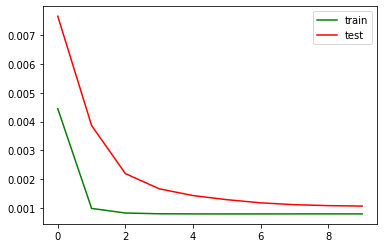

In [31]:
# 绘制训练损失和测试损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


/home/wll/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


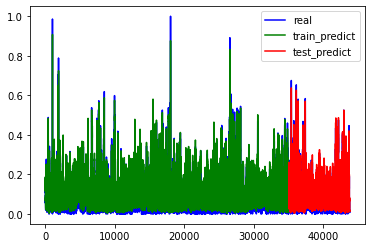

In [33]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_predict, test_predict):
    # 原始数据（蓝色）
    plt.plot(source_data_set[:, -1], label='real', c='b')
    # 训练数据（绿色）
    plt.plot([x for x in train_predict], label='train_predict', c='g')
    # 预测结果（红色）
    plt.plot([None for _ in train_predict]+[x for x in test_predict], label='test_predict', c='r')
    plt.legend(loc='best')
    plt.show()
# 绘制预测结果与实际结果的对比
plot_img(values, train_predict, test_predict)